In [1]:
import numpy as np
import random
import torch
torch.set_default_dtype(torch.float64)
from scipy.sparse.linalg import LinearOperator
import matplotlib.pyplot as plt
import torch.nn.functional as F

Tout d'abord on crée la fonction

In [12]:



class Problem() :
    def __init__(self,U,V,mu,nu,nb_messages=None,varepsilon=None,q=None) :
        ## L'ordre est (etat,message,action)
        self.V=V # Utilité du sender de taille (etat,action)
        self.mu=mu # Prior du sender de taille (etat)
        self.U=U # Utilité du reciever de taille (etat,action)
        self.nu=nu # Prior du reciever de taille (etat)
        self.varepsilon=varepsilon # Multiplicateur d'attache à une stratégie a priori (réel)
        self.q=q # Stratégie à priori du receiver de taille (messages,action)
        self.nb_messages=nb_messages
        self.check()
        self.size=self.nb_messages*self.nb_states # size of the input vector f is a function of \mathbb R^n to \mathbb R
        self.shape=(self.nb_states,self.nb_messages)
    def check(self) :
        self.nb_states, self.nb_actions=self.U.shape
        self.debug_shape(self.V,[self.nb_states, self.nb_actions])
        self.debug_shape(self.mu,[self.nb_states,])
        self.debug_shape(self.nu,[self.nb_states,])
        if self.q is not None :
            m,a=self.q.shape
            if self.nb_messages is None :
                self.nb_messages=m
            self.debug_shape(q,[self.nb_messages,self.nb_actions])
        if self.nb_messages is None :
            self.nb_messages=self.nb_actions
        if self.q is None and self.varepsilon is not None :
            self.q=np.ones((self.nb_messages,self.nb_actions))/self.nb_actions
    def debug_shape(self,vect,target_shape) :
        if not list(vect.shape)==target_shape :
            print('Found a vector of size ', vect.shape, 'expected ',target_shape)
            assert False
    def verbose(self,pi) :
        print('We have (state,message,action)=',self.nb_states,self.nb_messages,self.nb_actions)
        self.debug_shape(pi,[self.nb_states,self.nb_messages])
        theta=self.compute_theta(self.compute_g(pi))
        self.debug_shape(theta,[self.nb_messages,self.nb_actions])
        print('We have 1=',pi.sum(axis=1))
        print('We have 1=',theta.sum(axis=1))
        print('theta',theta)
        print('objective',self.objective(pi))
    def compute_g(self,pi):
        denominator=(pi*self.nu[:,None]).sum(axis=0)
        self.debug_shape(denominator,[self.nb_messages])
        g=(pi[:,:,None]*self.nu[:,None,None]*self.U[:,None,:]).sum(axis=0)
        self.debug_shape(g,[self.nb_messages,self.nb_actions])
        return g/denominator[:,None]
    def compute_theta(self,g):
        assert self.varepsilon is not None
        max_g,_=g.max(axis=1)
        exp=torch.exp((g-max_g[:,None])/self.varepsilon)
        self.debug_shape(exp,[self.nb_messages,self.nb_actions])
        theta=self.q*exp
        denom=theta.sum(axis=1)
        return theta/denom[:,None]

    def objective(self,pi):
        self.debug_shape(pi,[self.nb_states,self.nb_messages])
        g = self.compute_g(pi) # Calculer g en utilisant pi, U, et nu
        theta = self.compute_theta(g) # Calculer theta en utilisant g, q, et epsilon
        return (theta[None,:,:]*pi[:,:,None]*self.mu[:,None,None]*self.V[:,None,:]).sum()
    def objective_receiver(self,pi):
        self.debug_shape(pi,[self.nb_states,self.nb_messages])
        g = self.compute_g(pi) # Calculer g en utilisant pi, U, et nu
        theta = self.compute_theta(g) # Calculer theta en utilisant g, q, et epsilon
        return (theta[None,:,:]*pi[:,:,None]*self.nu[:,None,None]*self.U[:,None,:]).sum()
    def project(self,x):
        pi=torch.from_numpy(x)
        pi_projected=torch.zeros_like(pi)
        for i in range(pi.shape[0]):
            row = pi[i, :]
            sorted_row, _ = torch.sort(row, descending=True)
            cumulative_sum = torch.cumsum(sorted_row, dim=0)
            # Calcul de rho
            rho = torch.nonzero(sorted_row * torch.arange(1, len(row) + 1) > (cumulative_sum - 1), as_tuple=False).max()
            # Calcul du seuil theta
            theta = (cumulative_sum[rho] - 1) / (rho + 1)
            # Projection sur le simplexe
            pi_projected[i, :] = torch.clamp(row - theta, min=0)
        return pi_projected.numpy()
    def project_tangent(self,x,d) :
        d2=d-d.mean(axis=1)[:,None]
        d2[(x==0)*(d2<0)] =0.
        d2[(x==1)*(d2>0)] =0.
        return d2
    def value(self,x) : # returns the value of the function at point x wich is numpy
        assert x.shape==self.shape
        pi=torch.from_numpy(x).requires_grad_(True)
        f=self.objective(pi)
        f.backward()
        df=pi.grad
        return -f.item(),-df.numpy()
    
    def value_receiver(self,x) : # returns the value of the function at point x wich is numpy
        assert x.shape==self.shape
        pi=torch.from_numpy(x).requires_grad_(True)
        f=self.objective_receiver(pi)
        f.backward()
        df=pi.grad
        return -f.item(),-df.numpy()



On va maintenant charger une méthode linéaire de Wolfe

In [3]:
def dot(a,b) :
    return (a*b).sum()

def ls_wolfe(x,function,step,descent,f,df) :
    step_min,step_max=0.,np.inf
    scal=dot(df,descent)
    if scal > 0 :
        print('WARNING with scal',scal)
    step2=step
    eps1,eps2=1.e-4,0.9
    i=0
    while i<100 :
        i=i+1
        x2=function.project(x+step2*descent)
        f2,df2=function.value(x2)
        if dot(x2-x,df) >=0 :
            print('We have a problem',dot(x2-x,df),dot(descent,df))
        if f2>f+eps1*dot(x2-x,df) : # step is too big, decrease it
            step_max=step2
            step2=0.5*(step_min+step_max)
        else :
            if dot(df2,x2-x) < eps2*dot(df,x2-x) : # step is too small, increase it
                step_min=step2
                step2=min(0.5*(step_min+step_max),2*step_min)
            else :
                return x2,f2,df2,step2
    print('We do not exit Wolfe')
    print(f2>f+eps1*step2*scal,dot(df2,descent) < eps2*scal)
    return x2,f2,df2,step2


In [4]:
def optimize(function, itermax=5000, tol=1.e-6, verbose=True, x0=None):
    np.random.seed(42)
    # Utiliser x0 si fourni, sinon initialisation aléatoire
    if x0 is not None:
        x = np.copy(x0)
    else:
        x = np.random.randn(function.size).reshape(function.shape)
    x = function.project(x)
    list_costs = []
    list_grads = []
    nbiter = 0
    f, df = function.value(x)
    df_tangent = function.project_tangent(x, -df)
    norm_grad = np.linalg.norm(df_tangent)
    err = 2 * tol
    if verbose:
        print('iter={:4d} f={:1.3e} df={:1.3e}'.format(nbiter, f, err))
    list_costs.append(f)
    list_grads.append(norm_grad)
    while (err > tol) and (nbiter < itermax):
        descent = -df
        x_old = np.copy(x)
        x, f, df, step = ls_wolfe(x, function, 1., descent, f, df)
        norm_grad = np.linalg.norm(function.project_tangent(x, -df))
        list_costs.append(f)
        list_grads.append(norm_grad)
        err = norm_grad
        nbiter += 1
        if verbose:
            print('iter={:4d} f={:1.3e} err={:1.3e} s={:1.3e}'.format(nbiter, f, err, step))
        if err <= tol:
            if verbose:
                print("Success !!! Algorithm converged !!!")
            return x, list_costs, list_grads
    if verbose:
        print("FAILED to converge")


Et on obtient


In [11]:
alpha = 0.7
beta = 0.9
epsilon = 1e-2

U = torch.tensor([[1.0, 0.0],
                  [0.0, 1.0]])
V = torch.tensor([[0.0, 1.0],
                  [0.0, 1.0]])
mu = torch.tensor([alpha, 1 - alpha])
nu = mu
q = torch.tensor([beta, 1 - beta]).expand(2,2)
#pi0 = torch.tensor([[4/7, 3/7],
#                  [0, 1]])
P=Problem(U,V,mu,mu,varepsilon=epsilon,q=q)
x,costs,grad=optimize(P,tol=1.e-6,verbose=True)

iter=   0 f=-4.091e-01 df=2.000e-06
iter=   1 f=-4.351e-01 err=9.238e+00 s=6.250e-01
iter=   2 f=-4.380e-01 err=4.950e-01 s=3.125e-02
iter=   3 f=-5.561e-01 err=8.369e-02 s=5.000e-01
iter=   4 f=-5.562e-01 err=2.791e-02 s=3.125e-02
iter=   5 f=-5.562e-01 err=1.221e-02 s=3.125e-02
iter=   6 f=-5.562e-01 err=4.960e-03 s=3.125e-02
iter=   7 f=-5.562e-01 err=2.085e-03 s=3.125e-02
iter=   8 f=-5.562e-01 err=8.648e-04 s=3.125e-02
iter=   9 f=-5.562e-01 err=3.607e-04 s=3.125e-02
iter=  10 f=-5.562e-01 err=1.501e-04 s=3.125e-02
iter=  11 f=-5.562e-01 err=6.254e-05 s=3.125e-02
iter=  12 f=-5.562e-01 err=2.604e-05 s=3.125e-02
iter=  13 f=-5.562e-01 err=1.084e-05 s=3.125e-02
iter=  14 f=-5.562e-01 err=4.516e-06 s=3.125e-02
iter=  15 f=-5.562e-01 err=1.881e-06 s=3.125e-02
iter=  16 f=-5.562e-01 err=7.833e-07 s=3.125e-02
Success !!! Algorithm converged !!!


In [7]:
def optimize_with_q_update(function, max_outer_iter=10, itermax=5000, tol=1.e-7, verbose=True):
    np.random.seed(42)
    L_s = []
    L_r = []
    # Initialisation aléatoire de x
    x = np.random.randn(function.size).reshape(function.shape)
    x = function.project(x)
    list_costs = []
    list_grads = []
    outer_iter = 0

    while outer_iter < max_outer_iter:
        if verbose:
            print(f"Outer iteration {outer_iter + 1}/{max_outer_iter}")

        # Optimisation avec q actuel et x initialisé avec le résultat précédent
        x, costs, grads = optimize(function, itermax=itermax, tol=tol, verbose=False, x0=x)
        x = torch.tensor(x, dtype=torch.float64)  # Convertir en Tensor pour compatibilité
        list_costs.extend(costs)
        list_grads.extend(grads)

        # Mise à jour de q en tant que theta(pi)
        theta = function.compute_theta(function.compute_g(x))
        function.q = theta

        # Affichage des résultats de cette itération externe
        f_final = costs[-1]# Dernière valeur de f obtenue
        f_receiver = function.objective_receiver(x)
        L_s.append(f_final)
        L_r.append(f_receiver)
        if verbose:
            print(f"End of Outer Iteration {outer_iter + 1}: f = {f_final:.3e}, theta =\n{theta}")

        # Réinitialisation de x pour la prochaine itération avec le dernier pi optimal
        x = x.detach().numpy()  # Convertir en numpy si nécessaire pour `optimize`
        outer_iter += 1

    return x, list_costs, list_grads,L_s,L_r


Outer iteration 1/30
End of Outer Iteration 1: f = -2.299e-01, theta =
tensor([[0.9961, 0.0039],
        [0.2430, 0.7570]])
Outer iteration 2/30
End of Outer Iteration 2: f = -4.617e-01, theta =
tensor([[9.9986e-01, 1.4138e-04],
        [3.6137e-01, 6.3863e-01]])
Outer iteration 3/30
End of Outer Iteration 3: f = -3.885e-01, theta =
tensor([[9.9999e-01, 5.0444e-06],
        [2.6386e-01, 7.3614e-01]])
Outer iteration 4/30
End of Outer Iteration 4: f = -4.444e-01, theta =
tensor([[1.0000e+00, 1.7996e-07],
        [3.3323e-01, 6.6677e-01]])
Outer iteration 5/30
End of Outer Iteration 5: f = -4.018e-01, theta =
tensor([[1.0000e+00, 6.4197e-09],
        [2.7838e-01, 7.2162e-01]])
Outer iteration 6/30
End of Outer Iteration 6: f = -4.339e-01, theta =
tensor([[1.0000e+00, 2.2902e-10],
        [3.1816e-01, 6.8184e-01]])
Outer iteration 7/30
End of Outer Iteration 7: f = -4.096e-01, theta =
tensor([[1.0000e+00, 8.1700e-12],
        [2.8744e-01, 7.1256e-01]])
Outer iteration 8/30
End of Outer It

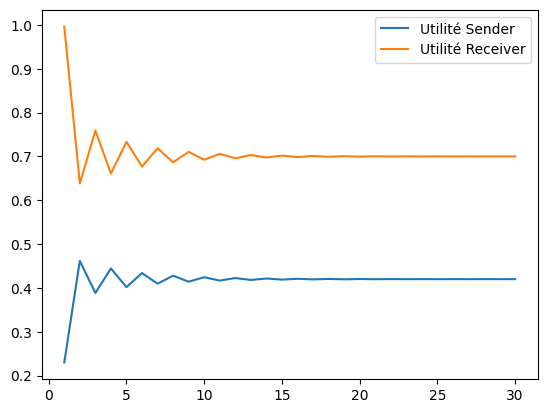

In [10]:
alpha = 0.7
beta = 0.9
epsilon = 3e-1
U = torch.tensor([[1.0, 0.0],
                  [0.0, 1.0]])
V = torch.tensor([[0.0, 1.0],
                  [0.0, 1.0]])
mu = torch.tensor([alpha, 1 - alpha])
nu = mu
q = torch.tensor([beta, 1 - beta]).expand(2,2)
#pi0 = torch.tensor([[4/7, 3/7],
#                  [0, 1]])
P=Problem(U,V,mu,mu,varepsilon=epsilon,q=q)


x,costs,grads, L_s, L_r = optimize_with_q_update(P, max_outer_iter=30, tol=1.e-7, verbose=True)

plt.plot(range(1, len(L_s) + 1), -np.array(L_s), label="Utilité Sender")
plt.plot(range(1, len(L_r) + 1), np.array(L_r), label="Utilité Receiver")
plt.legend()